In [1]:
import nltk

In [2]:
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [4]:
data = pd.read_csv('final.csv')

In [5]:
data.dropna(inplace=True)

In [6]:
data.drop(['Unnamed: 0','Upvote_ratio'], axis=1, inplace=True)

Title word count lengths: 
 Min: 1 
 Max: 63 
 Average: 8.571944853433275


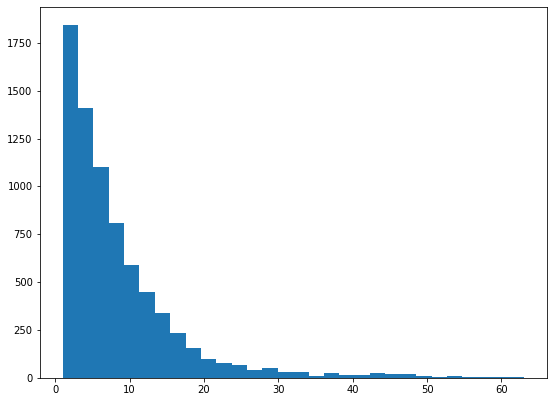

In [7]:
plt.figure(figsize=(20,15))
plt.subplot(221)
title_word_lengths = [len(str(data.Title.iloc[i]).split(' ')) for i in range(len(data))]
max_title_word_length = max(title_word_lengths)
min_title_word_length = min(title_word_lengths)
average_title_word_length = sum(title_word_lengths)/len(title_word_lengths)
plt.hist(title_word_lengths, bins = 30)
print('Title word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_title_word_length, max_title_word_length, average_title_word_length))


In [8]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_preprocess(text):
    text = re.sub(r'[^\w\s]', '', text) 
    l_text = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    stem_words = [stemmer.stem(w) for w in l_text]
    lemma_words = [lemmatizer.lemmatize(w) for w in l_text]

    return " ".join(lemma_words)

data['Title'] = data['Title'].map(lambda com : text_preprocess(com))

In [9]:
data.head()

,Title,Score,Gilded,Over_18,Number_of_Comments,neg,neu,pos,compound
0,house impeaches trump second time capitol riot,39464,2,False,8801,0.292,0.708,0.000,-0.5106
1,im 16 yr old blacksmith forged whale bottle op...,29423,0,False,443,0.000,0.633,0.367,0.8268
2,research spouting nonsense,50420,0,False,1008,0.351,0.649,0.000,-0.4019
3,moving box arrive white house,149858,6,False,4392,0.000,1.000,0.000,0.0000
4,took seriously black cop warned racist capitol...,7768,0,False,157,0.319,0.681,0.000,-0.7269


In [10]:
i = 0

predicted_value = []

while i<len(data):
  if (data.loc[i]['compound'] >= 0.5):
    predicted_value.append('positive')
    i = i+1

  elif (data.loc[i]['compound'] >= 0) & (data.loc[i]['compound'] <= 0.5):
    predicted_value.append('neutral')
    i = i+1

  elif (data.loc[i]['compound'] <= 0):
    predicted_value.append('negative')
    i = i+1

In [11]:
data['Predicted_value'] = predicted_value

In [12]:
data.head()

,Title,Score,Gilded,Over_18,Number_of_Comments,neg,neu,pos,compound,Predicted_value
0,house impeaches trump second time capitol riot,39464,2,False,8801,0.292,0.708,0.000,-0.5106,negative
1,im 16 yr old blacksmith forged whale bottle op...,29423,0,False,443,0.000,0.633,0.367,0.8268,positive
2,research spouting nonsense,50420,0,False,1008,0.351,0.649,0.000,-0.4019,negative
3,moving box arrive white house,149858,6,False,4392,0.000,1.000,0.000,0.0000,neutral
4,took seriously black cop warned racist capitol...,7768,0,False,157,0.319,0.681,0.000,-0.7269,negative


In [13]:
data.drop(['neg', 'neu', 'pos', 'compound'], axis=1, inplace=True)

In [14]:
X = data.drop(['Score'], axis=1)
y = data['Score']

In [15]:
lengths = max([len(x) for x in X.Title])
lengths


271

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train["Title"])

In [18]:
train_title = tokenizer.texts_to_sequences(X_train["Title"])
test_title = tokenizer.texts_to_sequences(X_test["Title"])

vocab_size = len(tokenizer.word_index) + 1

In [19]:
indixes = tokenizer.word_index
tokens = {k:[indixes[k]] for k in indixes}
df_tokens = pd.DataFrame(tokens)
df_tokens.to_csv('tokens.csv', header=True, index=False)

In [20]:
maxlen = 300

train_title = pad_sequences(train_title, padding='post', maxlen=maxlen)
test_title = pad_sequences(test_title, padding='post', maxlen=maxlen)

In [22]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [23]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
df = pd.DataFrame(data=embedding_matrix.astype(float))
df.to_csv('embedded.csv', sep=' ', header=True, float_format='%.2f', index=False)

In [25]:
train_new = {}
for i, sentence in enumerate(train_title):
    vectors = []
    for n in sentence:
        vectors.append(embedding_matrix[n])
    train_new[i] = vectors

In [26]:
test_new = {}
for i, sentence in enumerate(test_title):
    vectors = []
    for n in sentence:
        vectors.append(embedding_matrix[n])
    test_new[i] = vectors

In [27]:
X_train_df = []
for key in train_new:
    arr = np.array(train_new[key])
    X_train_df.append(np.mean(arr, axis=0))

In [28]:
X_test_df = []
for key in test_new:
    arr = np.array(test_new[key])
    X_test_df.append(np.mean(arr, axis=0))

In [29]:
X_train_df = pd.DataFrame(np.array(X_train_df))
X_test_df = pd.DataFrame(np.array(X_test_df))

In [30]:
from sklearn.preprocessing import OneHotEncoder

categories = ['Over_18', 'Predicted_value']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[categories])
pickle.dump(enc, open('one_hot.pkl','wb'))

In [31]:
col_names = [j for sub in enc.categories_ for j in sub] 

In [32]:
col_names

[False, True, 'negative', 'neutral', 'positive']

In [33]:
train_encoded = enc.transform(X_train[categories])
test_encoded = enc.transform(X_test[categories])

In [34]:
X_train.drop(["Title", 'Over_18', 'Predicted_value'], axis=1, inplace=True)
X_test.drop(["Title", 'Over_18', 'Predicted_value'], axis=1, inplace=True)

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [36]:
train = pd.DataFrame(train_encoded.todense(), columns=col_names)
test = pd.DataFrame(test_encoded.todense(), columns=col_names)

In [37]:
train.head()

,False,True,negative,neutral,positive
0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0


In [38]:
X_train = pd.concat([X_train, X_train_df, train], axis=1)
X_test = pd.concat([X_test, X_test_df, test], axis=1)

In [39]:
X_train.head()

,Gilded,Number_of_Comments,0,1,2,3,4,5,6,7,...,95,96,97,98,99,False,True,negative,neutral,positive
0,0,78,0.000034,0.002795,0.001645,-0.006825,0.002544,0.005077,0.002079,0.006457,...,0.002464,-0.002154,0.001094,0.010081,-0.001663,1.0,0.0,1.0,0.0,0.0
1,0,121,-0.003888,0.008964,-0.000934,-0.006382,0.003160,0.007403,0.006735,0.006071,...,-0.000138,-0.004328,-0.003977,0.019336,0.003358,1.0,0.0,0.0,1.0,0.0
2,0,21,-0.007732,-0.001875,-0.001212,-0.000843,-0.006848,-0.002804,-0.001028,0.003627,...,0.000302,0.002026,-0.005322,0.000607,-0.005002,1.0,0.0,0.0,1.0,0.0
3,0,1814,0.000868,0.003407,-0.001461,-0.002930,-0.000030,0.004871,-0.002819,-0.000101,...,-0.001414,-0.000641,-0.000142,0.008797,0.003983,1.0,0.0,1.0,0.0,0.0
4,0,5,0.000660,0.002280,0.001765,-0.001186,-0.002837,0.000163,-0.000390,0.000204,...,-0.000623,0.000001,-0.000905,-0.002055,0.002244,1.0,0.0,0.0,1.0,0.0


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

Linear Regression

In [41]:
lm=LinearRegression()   
lm = lm.fit(X_train,y_train)

#Traindata Predictions
train_pred = lm.predict(X_train)

#testdata predictions
test_pred = lm.predict(X_test)


RMSE_test = np.sqrt(mean_squared_error(y_test, test_pred))
RMSE_train= np.sqrt(mean_squared_error(y_train,train_pred))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',lm.score(X_train, y_train))
print('RSquared value on test:',lm.score(X_test, y_test))

RMSE TrainingData =  8725.181109824134
RMSE TestData =  8264.990232924927
--------------------------------------------------
RSquared value on train: 0.348249758216276
RSquared value on test: 0.3209152201390554


Decision Tree Regressor

In [42]:
DT=DecisionTreeRegressor()
DT.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [43]:
#predicting train
train_preds=DT.predict(X_train)
#predicting on test
test_preds=DT.predict(X_test)

In [44]:
RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',DT.score(X_train, y_train))
print('RSquared value on test:',DT.score(X_test, y_test))

RMSE TrainingData =  417.88206963549027
RMSE TestData =  10581.84167087426
--------------------------------------------------
RSquared value on train: 0.9985050048835431
RSquared value on test: -0.1131708517243859


Random Forest Regression

In [45]:
RF=RandomForestRegressor(n_jobs=-1)
RF.fit(X_train,y_train)

#predicting train
train_preds1=RF.predict(X_train)
#predicting on test
test_preds1=RF.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds1)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds1)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',RF.score(X_train, y_train))
print('RSquared value on test:',RF.score(X_test, y_test))

RMSE TrainingData =  2837.5640486683174
RMSE TestData =  7459.975979822178
--------------------------------------------------
RSquared value on train: 0.9310675608314705
RSquared value on test: 0.44675924453898364


In [47]:
RF=RandomForestRegressor(n_jobs=-1)
RF.fit(X_train,y_train)

pickle.dump(RF, open('rf_regress.pkl','wb'))

K Nearest Neighbors

In [48]:
knn=KNeighborsRegressor()
knn.fit(X_train,y_train)

#predicting train
train_preds2=knn.predict(X_train)
#predicting on test
test_preds2=knn.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds2)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds2)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',knn.score(X_train, y_train))
print('RSquared value on test:',knn.score(X_test, y_test))

RMSE TrainingData =  6606.932735711041
RMSE TestData =  8634.922128544069
--------------------------------------------------
RSquared value on train: 0.6262922789509617
RSquared value on test: 0.25876458977024996
